In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, auc, classification_report

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 40
CHANNELS = 1
EPOCHS = 50

In [4]:
dataset = tf.keras.utils.image_dataset_from_directory(
    "TumorData",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    color_mode="grayscale",
    shuffle=True,  
)


    

Found 2870 files belonging to 4 classes.


In [5]:
class_names = dataset.class_names
class_names

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [6]:
len(dataset) #shows the number of batchs for the whole dataset

72

In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)
    

(256, 256, 1)


In [8]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(40, 256, 256, 1)
[1 1 2 0 1 1 1 3 3 1 3 2 0 1 3 3 1 1 2 1 3 3 0 3 1 0 3 1 0 1 1 1 1 2 0 2 2
 3 3 0]


In [9]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0])

tf.Tensor(
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]], shape=(256, 256, 1), dtype=float32)


In [10]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]


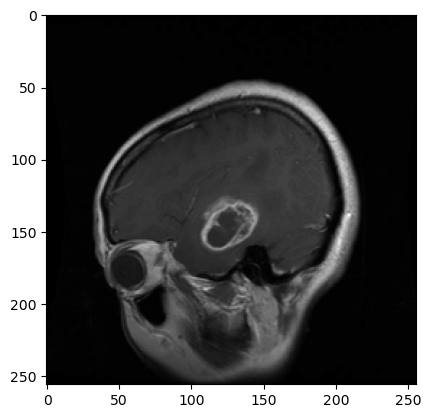

In [11]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy(), cmap='gray')
    
    

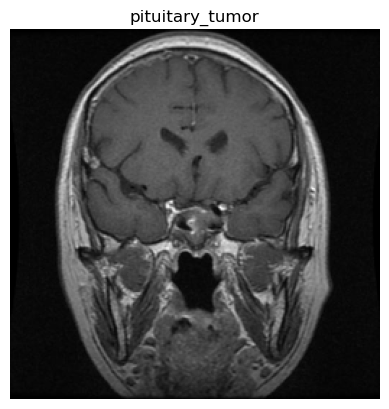

In [12]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy(), cmap='gray')
    plt.title(class_names[label_batch[0]])
    
    

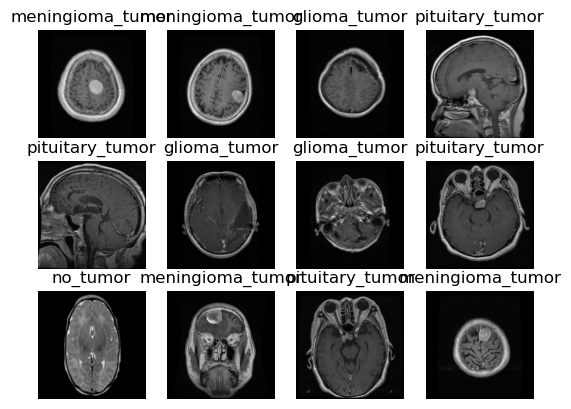

In [13]:
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax =plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy(), cmap='gray')
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

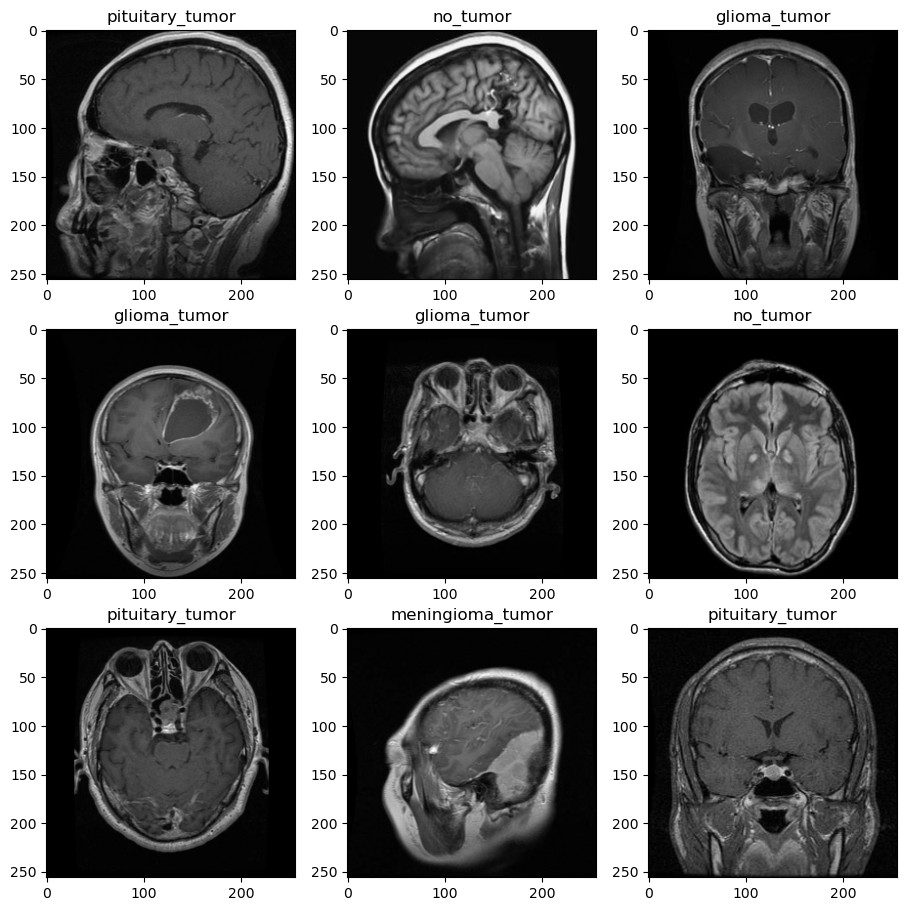

In [14]:
plt.figure(figsize=(11, 11))

for image_batch, label_batch in dataset.take(1):
    for i in range(9):
        ax =plt.subplot(3,3,i+1)  
        plt.imshow(image_batch[i].numpy(), cmap='gray')
        plt.title(class_names[label_batch[i]])
        

In [15]:
len(dataset)

72

In [16]:
training_percentage = 0.8
validation_percentage = 0.1
test_percentage = 0.1


In [17]:
train_size = 0.8
len(dataset) * train_size


57.6

In [18]:
train_ds = dataset.take(57)
len(train_ds)


57

In [19]:
test_ds = dataset.skip(57)
len(test_ds)

15

In [20]:
val_size = 0.1
len(dataset) * val_size

7.2

In [21]:
val_ds = dataset.take(7)
len(val_ds)

7

In [22]:
test_ds = test_ds.skip(7)
len(test_ds)

8

In [23]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle_size=1000):
    ds_size = len(ds)
    
    shuffle = True 
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [24]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [25]:
len(train_ds)

57

In [26]:
len(val_ds)

7

In [27]:
len(test_ds)

8

In [28]:
#train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
#val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
#test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [29]:
resize_and_rescale = tf.keras.Sequential( [
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
] )

In [30]:
data_augmentation = tf.keras.Sequential( [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
   
   
])

In [31]:

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4
""""model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(64, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')  
])

model.build(input_shape=input_shape)

"""
model = models.Sequential([
    # ... Your previous layers ...
    
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),  # Adding dropout for regularization
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),  # Adding dropout for regularization
    
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [32]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (40, 254, 254, 128)       1280      
                                                                 
 max_pooling2d (MaxPooling2  (40, 127, 127, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (40, 125, 125, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (40, 62, 62, 128)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (40, 60, 60, 128)         147584    
                                                                 
 max_pooling2d_2 (MaxPoolin  (40, 30, 30, 128)        

In [33]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [34]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
57/57 [==============================] - 572s 9s/step - loss: 4.0522 - accuracy: 0.3728 - val_loss: 1.0613 - val_accuracy: 0.5607
Epoch 2/50
57/57 [==============================] - 469s 8s/step - loss: 1.1602 - accuracy: 0.4573 - val_loss: 0.9047 - val_accuracy: 0.6250
Epoch 3/50
57/57 [==============================] - 487s 9s/step - loss: 1.0304 - accuracy: 0.5401 - val_loss: 0.8177 - val_accuracy: 0.6536
Epoch 4/50
57/57 [==============================] - 446s 8s/step - loss: 0.9224 - accuracy: 0.6031 - val_loss: 0.7037 - val_accuracy: 0.7250
Epoch 5/50
57/57 [==============================] - 434s 8s/step - loss: 0.8566 - accuracy: 0.6361 - val_loss: 0.6394 - val_accuracy: 0.7571
Epoch 6/50
57/57 [==============================] - 461s 8s/step - loss: 0.7932 - accuracy: 0.6722 - val_loss: 0.5201 - val_accuracy: 0.7893
Epoch 7/50
57/57 [==============================] - 449s 8s/step - loss: 0.7635 - accuracy: 0.6916 - val_loss: 0.5134 - val_accuracy: 0.7667
Epoch 8/50
57

In [35]:
score = model.evaluate(test_ds)

8/8 [==============================] - 17s 2s/step - loss: 0.0460 - accuracy: 0.9875


In [36]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Trainning and Validation Loss')

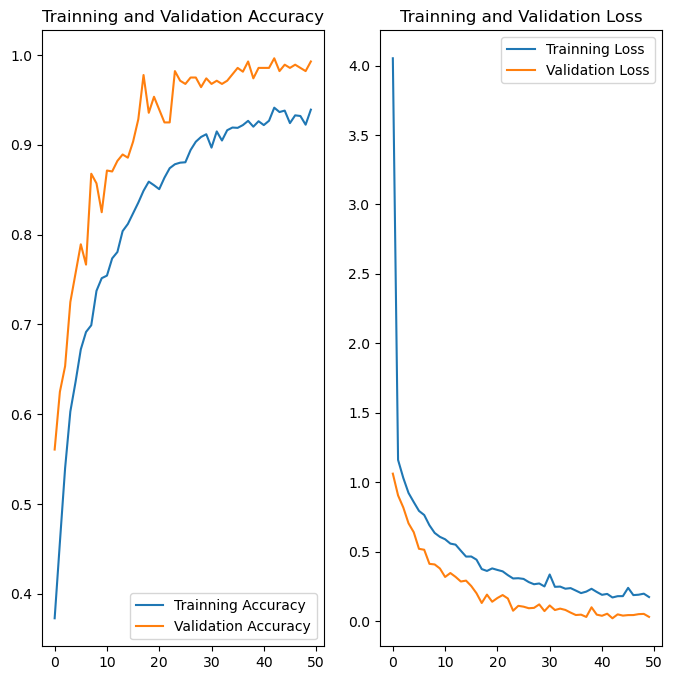

In [47]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence
    

1/1 [==============================] - 0s 81ms/step


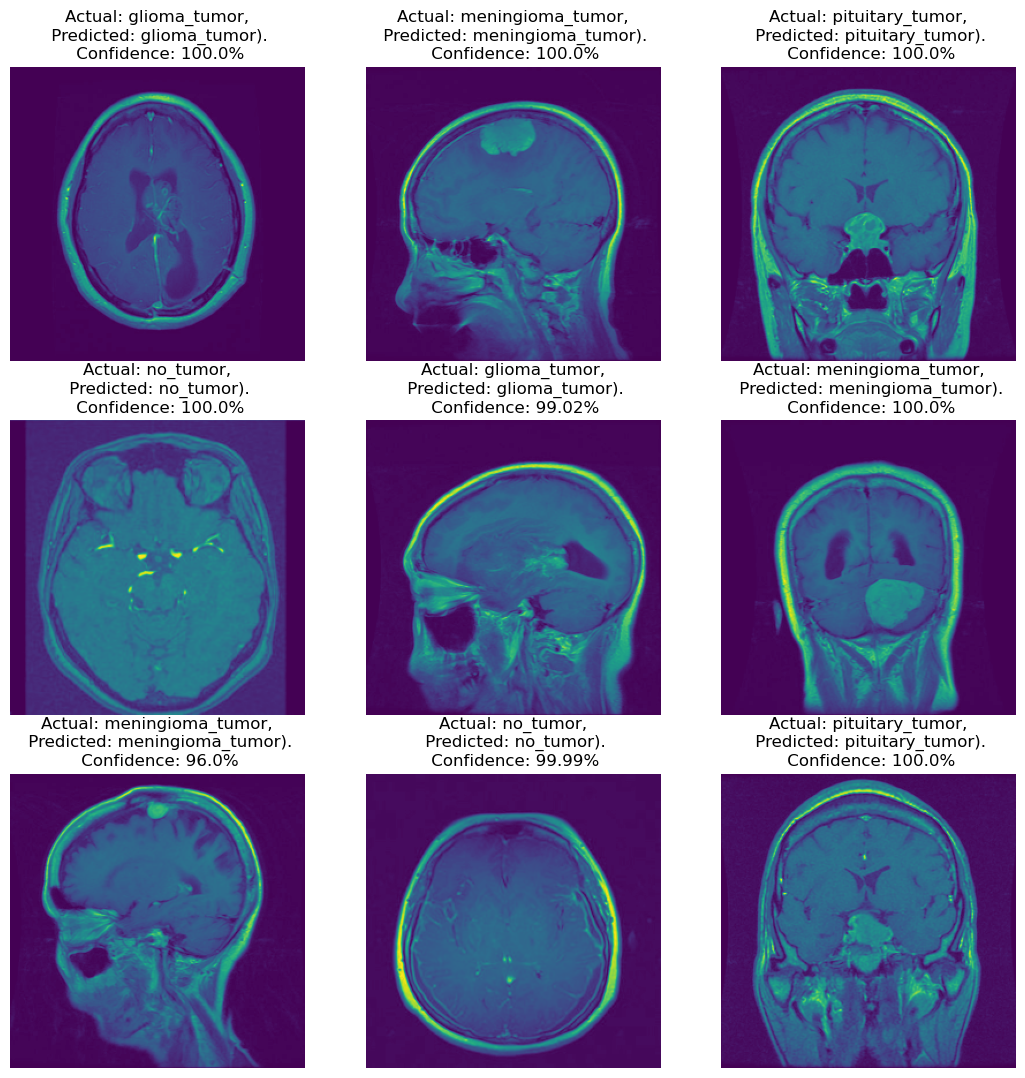

In [60]:
plt.figure(figsize=(13, 13))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}).\n Confidence: {confidence}%")

        plt.axis("off")